# Modeling Crop Yield

In [57]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

## Parameters

In [196]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2-l2a"

# bands = "2-3-4"
bands = "2-3-4-8"
# bands = "2-3-4-5-6-7"

country_code = "ZMB"

points = "4"
# points = "15"
# points = "24"
# points = "42"

num_features = "1000"

feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}k-points_{num_features}-features')
weight_file_name = (f'{country_code}_crop_weights{points}k-points')

year_start = 2015
year_end = 2018

if points == "4":
    marker_sz = 60
elif points == "15":
    marker_sz = 20
elif points == "24":
    marker_sz = 10
else:
    marker_sz = 8

## Boundaries 

In [59]:
country_shp = geopandas.read_file(f'/capstone/cropmosaiks/data/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(column = 'district',linewidth = 1, edgecolor = 'black' )
# country_shp

(72, 1)

## Crops

In [60]:
crop_df = pd.read_csv('/capstone/cropmosaiks/data/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
ln = len(crop_df[crop_df.year == 2016].district)
crop_df = crop_df.set_index('district')
ln
# crop_df

74

In [61]:
list(set(crop_districts) - set(country_districts))

['Mafinga', 'Ikelenge']

In [62]:
list(set(country_districts) - set(crop_districts))

[]

In [63]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Weights

In [64]:
# weights = pd.read_feather(f"data/weights/{weight_file_name}_2018.feather")
# weights.crop_perc = weights.crop_perc.fillna(0)
# weights.crop_perc = weights.crop_perc + 0.0001
# weights

In [65]:
# weights_gdf.plot(figsize = (15,15),
                 # cmap = 'inferno',
                 # cmap = new_cmap,
                 # markersize = 3,
                 # alpha = .9,
                 # column = 'crop_perc')
# plt.axis('off')

## Features

In [187]:
features_raw = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"/capstone/cropmosaiks/data/features/{feature_file_name}_{yr}.feather")
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features_raw = pd.concat([features_raw, features_x], axis=0)
    
    print("feature.shape", features_raw.shape)
    print("Appending:", yr)
    print("")

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_4k-points_1000-features_2015.feather
feature.shape (5530, 1004)
Appending: 2015

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_4k-points_1000-features_2016.feather
feature.shape (39545, 1004)
Appending: 2016

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_4k-points_1000-features_2017.feather
feature.shape (65088, 1004)
Appending: 2017

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_4k-points_1000-features_2018.feather
feature.shape (102350, 1004)
Appending: 2018



In [188]:
features = features_raw.copy()
if year_start == 2013:
    features = features[features.month > 6]
else:
    pass

features['year'] = np.where(
    features['month'].isin([7, 8, 9, 10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features = features[features['year'] <= year_end]

features.sort_values(['year', 'month'], inplace=True)

In [189]:
# Here we pivot the data from long format to wide by indexing on 
# 'lon','lat', "year", 'month' and using the unstack function
features = features.set_index(['lon','lat', "year", 'month']).unstack()

# We then map column names based on the month index and the associated features
# so month '01' is appended to each feature for that month making 0_01, 1_01 etc. 
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

In [190]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)

In [191]:
impute_data = True
# impute_data = False

if impute_data:
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()
else:
    features = features.fillna(0)

In [192]:
features = geopandas.GeoDataFrame(
    features, 
    geometry = geopandas.points_from_xy(x = features.lon, y = features.lat)
    , crs='EPSG:4326'
)#.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat']) # Optionally attach weight to each point (% area cropped of surrounding 1 km^2)
# Drop lon and lat now that they are in geometry column
features = features.drop(['lon', 'lat'], axis = 1)

<AxesSubplot:>

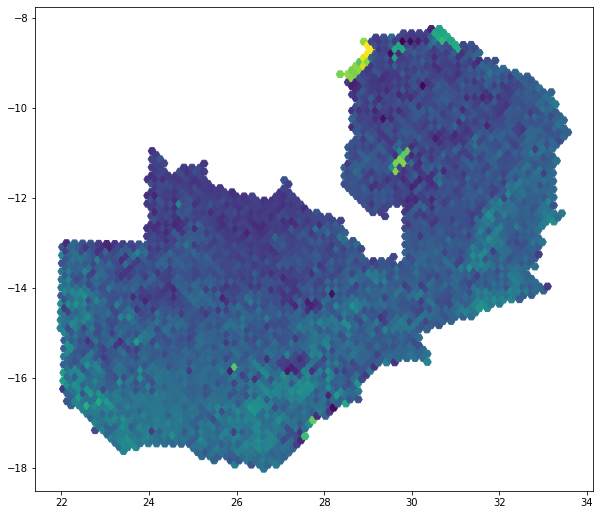

In [195]:
mn = 9
yr = 2017
feature = 999

features[features.year == yr].plot(
    column = f"{feature}_{mn}",
    figsize = (10,10),
    marker='H',
    # legend = True,
    markersize = marker_sz,
)

In [153]:
features = features.sjoin(country_shp, how = 'left', predicate = 'within')

In [154]:
# features

In [155]:
# na = features[adm_features.isna().any(axis = 1)]
# na.plot(figsize = (10,10), markersize = 10)

In [156]:
features = (
    features
    .dropna(subset=['index_right'])
    .rename(columns = {
        "index_right": "district", 
    })
    .reset_index(drop = True)
)
features_gdf = features.copy()
features = features.drop(['geometry'], axis = 1)

In [157]:
# features

In [158]:
features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

In [159]:
crop_df_x = crop_df[crop_df.year >= year_start + 1]
crop_df_x = crop_df_x[~crop_df_x.index.isin(['Mafinga', 'Ikelenge'])]
crop_df_x.reset_index(inplace=True)
# crop_df_x

In [160]:
features_summary = features_summary.set_index(["district", "year"]).join(other = crop_df_x.set_index(["district", "year"])).reset_index()
# features_summary

In [161]:
# features_croppped = features[features.crop_perc > 0]
# features.shape

In [162]:
# features_summary = features.groupby(['district', 'yield_mt' ,"year"], as_index = False
#                                    ).apply(lambda x: np.average(x['0'], weights=x['crop_perc'], axis = 0))
# features_summary

## Model

In [163]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [164]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [165]:
len(y_all)

216

In [166]:
len(x_train)

172

In [167]:
len(x_test)

44

In [168]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [169]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.29


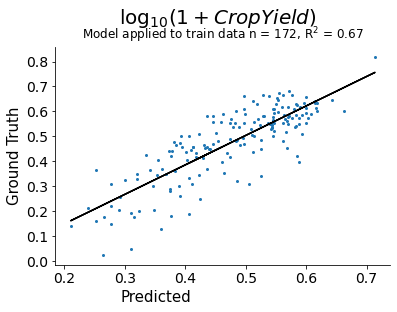

In [170]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [171]:
r2_score(y_train, y_pred)

0.6708655935476119

In [172]:
pearsonr(y_pred, y_train)

(0.8288280349379336, 9.838692797411592e-45)

In [173]:
spearmanr(y_pred, y_train)

SpearmanrResult(correlation=0.8005202547974991, pvalue=1.2065074492846848e-39)

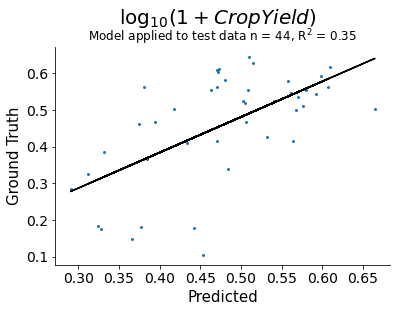

In [174]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [175]:
r2_score(y_test, y_pred)

0.35460821546525423

In [176]:
pearsonr(y_pred, y_test)

(0.6088300616238891, 1.1592635786639588e-05)

In [177]:
spearmanr(y_pred, y_test)

SpearmanrResult(correlation=0.5681465821000704, pvalue=5.750367458746816e-05)

In [179]:
pred_features = features.copy()
pred_features['geometry'] = features_gdf['geometry']
pred_features = geopandas.GeoDataFrame(pred_features)
x_all = pred_features.drop(['year', 'district', 'geometry', 
#                             'yield_mt'
                           ], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [180]:
plot_features = pred_features[pred_features.year == 2018]
# plot_features

<AxesSubplot:>

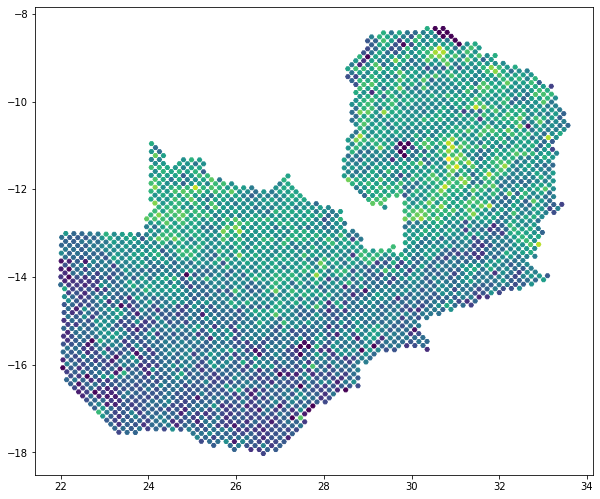

In [181]:
plot_features.plot(figsize = (10,10),
                   marker='H',
                   # legend = True,
                   markersize = marker_sz,
#                    alpha = .9,
                   column = 'fit')

In [52]:
# this is a comment

## Plot Residuals

In [182]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

residual_df = pd.DataFrame()

residual_df["yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
residual_df = residual_df.join(country_shp, how = "left", on = "district")
residual_gdf = geopandas.GeoDataFrame(residual_df)

Text(0.5, 1.0, '2016 Residuals')

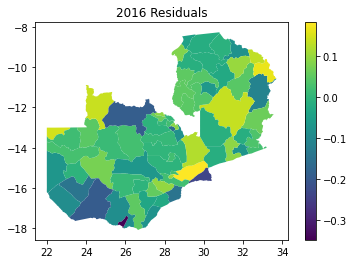

In [183]:
year = 2016
residual_gdf[residual_gdf.year == year].plot(column = "residual", legend = True)
plt.title(f"{year} Residuals")

Text(0.5, 1.0, '2017 Residuals')

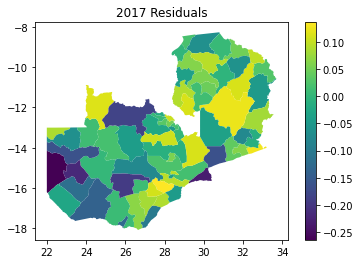

In [184]:
year = 2017
residual_gdf[residual_gdf.year == year].plot(column = "residual", legend = True)
plt.title(f"{year} Residuals")

Text(0.5, 1.0, '2018 Residuals')

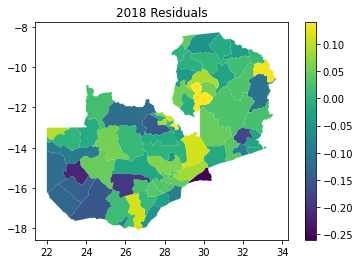

In [185]:
year = 2018
residual_gdf[residual_gdf.year == year].plot(column = "residual", legend = True)
plt.title(f"{year} Residuals")